### IMPORT LIBRARY

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import math
import pandas as pd
from scipy.fftpack import fft, fftfreq, ifft

### IMPORT SIGNALS

In [2]:
y = pd.read_csv("C:/Users/ASUS/Documents/GitHub/sound-noise-reduction-signal-processing/ESP32-INMP441-ArduinoIDE/sound_samples_voicenoised.csv")
y.head()

,Sample
0,0
1,0
2,0
3,0
4,0


### PLOT SIGNAL

In [3]:
samplingFreq = 10000 # sampled at 10 kHz frequency = 10000 sample/s
tlims = [0,10]       # time duration in second (s)
time = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)

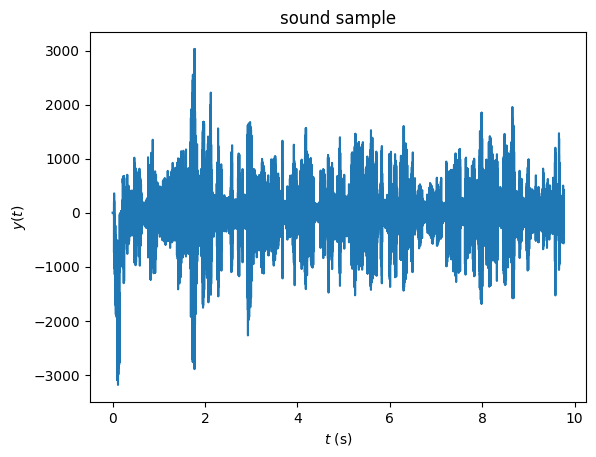

In [4]:
plt.plot(time[:97613], y)   # didnt use all 10s of time cause of data sampled <100,000 sample (10kHz on 10s)
plt.title("sound sample")
plt.ylabel("$y(t)$");
plt.xlabel("$t$ (s)");

### FFT SIGNAL

In [7]:
# compute spectrum
yhat=fft(y)
N = len(y)
fcycles=fftfreq(N,1/samplingFreq)
Fpositive=np.where(fcycles>=0)      # take only the positive part of freq

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13152\2371759368.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega$ (cycles/s)")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13152\2371759368.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$|\hat{y}|$")


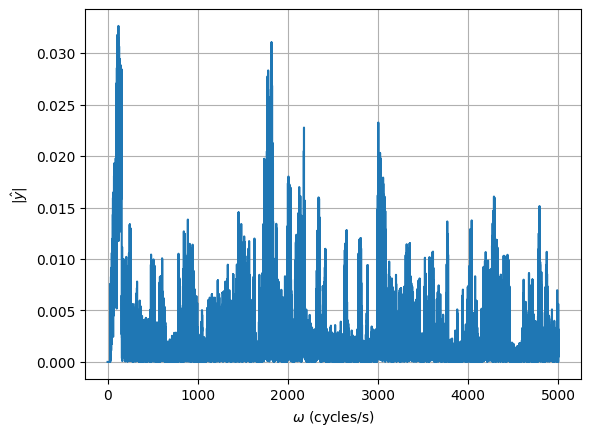

In [8]:
# plot fft result
plt.plot(fcycles[fcycles>0],np.absolute(yhat[fcycles>0])/N)

plt.xlabel("$\omega$ (cycles/s)")
plt.ylabel("$|\hat{y}|$")
plt.grid()

### TRANSFER FUNCTION BUTTERWORTH LOW PASS FILTER
*cut-off frequency ($\omega_c$) is 4900 (low pass)


In [48]:
# Butterworth filter
wc = 2*np.pi*4900; # Frekuensi cut-off (rad/s), dimana fc = 4900 Hz
n = 2;          # n= Orde Filter

# Hituung Koefisien Butterworth filter
a = np.zeros(n+1)
gamma = np.pi/(2.0*n)
a[0] = 1; # Koef. pertama selalu 1
for k in range(0,n):
    rfac = np.cos(k*gamma)/np.sin((k+1)*gamma)
    a[k+1] = rfac*a[k]; # Koef. Rekursif lain

print("Koef. Polinomial Butterworth (a_i):                              " + str(a))

# Adjust the cutoff frequency
c = np.zeros(n+1)
for k in range(0,n+1):
    c[n-k] = a[k]/pow(wc,k)

print("Koef. Polinomial Butterworth dengan Penyesuaian frekuensi (c_i): " + str(c))

Koef. Polinomial Butterworth (a_i):                              [1.         1.41421356 1.        ]
Koef. Polinomial Butterworth dengan Penyesuaian frekuensi (c_i): [1.05498942e-09 4.59345059e-05 1.00000000e+00]


In [ ]:
# Low-pass filter
w0 = 2*np.pi*4900; # frekuensi cut-off (rad/s), frekuensi cut-off dipilih 4900 Hz
num = [1];      # koefisien pembilang (numerator) dari fungsi alih
den = c;        # koefisien penyebut (denominator) dari fungsi alih
lowPass = signal.TransferFunction(num,den) # Generate fungsi alih


### DISCRETE TRANSFER FUNCTION

In [50]:
# # Mengubah Fungsi alih analog menjadi Fungsi alih diskrit dengan delta_t = 1/samplingFrequency
dt = 1.0/samplingFreq
discreteLowPass = lowPass.to_discrete(dt,method='gbt',alpha=0.5)
print(discreteLowPass)

TransferFunctionDiscrete(
array([0.4272252, 0.8544504, 0.4272252]),
array([1.        , 0.49387595, 0.21502486]),
dt: 0.0001
)


In [51]:
y = y.to_numpy()  # Convert to a NumPy array

### CALCULATE COEFFICIENT AND APPLY IT OFFLINE

Filter coefficients b_i: [0.4272252 0.8544504 0.4272252]
Filter coefficients a_i: [-0.49387595 -0.21502486]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23280\19926998.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yfilt[m] = b[0]*y[m]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23280\19926998.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i]


Text(0, 0.5, '$y(t)$')

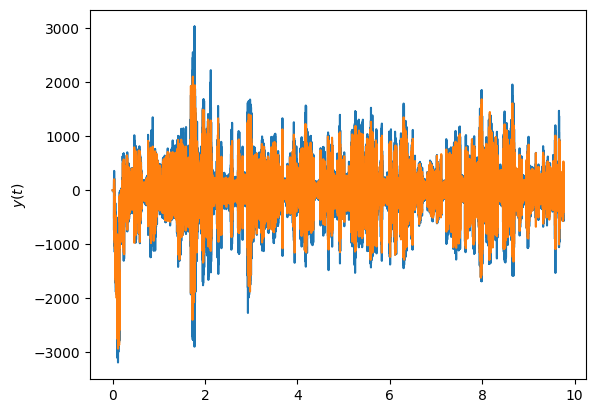

In [57]:
# Panggil koefisien Filter dari Fungsi alih diskrit sebelumnya (dengan negative sign)
b = discreteLowPass.num
a = -discreteLowPass.den
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Implementasi Filter Sinyal Menggunakan Persamaan Beda
Nb = len(b)
yfilt = np.zeros(len(y))
for m in range(3,len(y)):
    yfilt[m] = b[0]*y[m]
    for i in range(1,Nb):
        yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i]

# Plot Sinyal Input x(n) dan Output terfilter y(n)
plt.figure()
plt.plot(time[:97613],y)
plt.plot(time[:97613],yfilt)
plt.ylabel("$y(t)$")
